# Simulate data

This project uses the CMU_ARCTIC database, which is a speech database in CMU_ARCTIC speech synthesis databases, established by the Language Technologies Institute of Carnegie Mellon University, USA. This database is mainly used in the research of speech synthesis. The content of the corpus database was selected by the non-copyright center of Project Gutenberg, which is about 1150 sentences. An audio of two males and two females with American English accents were collected. The recording format is 16 bits, the sampling rate is 32 KHz, and the length of each sentence is 3 seconds. The database has a total of 4528 audio files.

## Imports

In [23]:
import math
import sys
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
from scipy.io import wavfile
from scipy import signal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize

## Constants

In [32]:
# Label resolution of angles
RESOLUTION = 10

# Number of samples to include while creating one ML feature
SAMPLES = 2048

# Determines the overlap of samples between consecutive features
STEP = 1024

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 2]),
    'medium' : np.array([6, 6, 2]),
    'large' : np.array([8, 8, 2])
}

# Testing rooms dimensions
TEST_ROOMS = {
    'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    'large' : np.array([9, 9, 2])
}

class Path:
    def __init__(self, name, path, max_angle):
        self.name = name
        self.path = path
        self.max_angle = max_angle

AUDIO_PATH = [
    Path('full', 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\full_circle', 360),
    Path('half', 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\half_circle', 180)
]

## Definition for rooms, microphones and sources

In [33]:
def create_simulation_room(room_dim=[4, 4, 2], mic_pos=[2, 2, 0], room_fs=16000):    
    # Initialize room
    room = pra.ShoeBox(room_dim, fs=room_fs, max_order=0)
    w = room_dim[0]
    l = room_dim[1]
    h = room_dim[2]

    # Generate the microphones
    mic_pos = np.c_[[w/2+0.2, l/2, h/2],[w/2-0.2, l/2, h/2]] 
    room.add_microphone_array(mic_pos)
    
    return room


def create_sound_sources(max_angle, room_dim=[4, 4, 2], resolution=RESOLUTION):        
    # Specify angle in distance ranges
    if max_angle == 180 : max_angle += 1
    angle_range = range(0, max_angle, resolution)
    dist_range = [1., 2.]
    height_range = [room_dim[-1]/2]
    sources = defaultdict(list)

    for angle in angle_range:
        for R in dist_range:
            for h in height_range:
                source = [R * math.cos(math.radians(angle)) + room_dim[0] / 2, 
                            R * math.sin(math.radians(angle)) + room_dim[1] / 2, h]
                sources[angle].append((R, h, source))
    return sources


def simulate_room(audio_file, subset, path, room_type='small', mic_pos=[2, 2, 0], label_res=20):
    file_name = os.path.basename(audio_file).split('.')[0]

    # Read the audio file
    fs, audio = wavfile.read(audio_file)
    
    # Get room dimensions
    if subset == 'train':
        room_dim = ROOMS[room_type]
    else:
        room_dim = TEST_ROOMS[room_type]

    # Create all sound sources
    sources = create_sound_sources(path.max_angle, room_dim)

    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        if angle % label_res == 0:
            print(f'\nSimulating {angle}-{angle + label_res - 1} degrees:', end=' ')
            
        sys.stdout.write("#")
        
        wav_signals = defaultdict(list)
        
        for dist, height, source in sources:
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=fs)
            room.add_source(source, signal=audio, delay=0.0)
            room.simulate()

            # Extract simulated signal for each microphone
            data = room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            
            # Append simulated data to the final WAV signals
            wav_signals[dist].extend(data)
            
        # Save WAV files containing 2 channel data for all distances at given angle
        for dist in wav_signals:
            save_name = f'{subset}_angle_{angle}_dist_{int(dist*100)}_room_{room_type}_{file_name}.wav'
            wavfile.write(f'{path.path}/{save_name}', 16000, np.array(wav_signals[dist]))
            
    print('\nSimulation successful!')

## Run simulations

In [34]:
print('Simulating training data:')

for path in AUDIO_PATH:
    print(f'Source type: {path.name}')

    for room, dim in ROOMS.items():
        # Call the function above and store all results
        print(f'Room: {room}')
        sound_files = "C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0014.wav"
        simulate_room(sound_files, 'train', path, room, dim / 2, label_res=90)


    print('Simulating test data:')
    for room, dim in ROOMS.items():
        # Call the function above and store all results
        print(f'Room: {room}')
        sound_files = "C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0015.wav"
        simulate_room(sound_files, 'test', path, room, dim / 2, label_res=90)


Simulating training data:
Source type: full
Room: small

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #########
Simulating 270-359 degrees: #########
Simulation successful!
Room: medium

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #########
Simulating 270-359 degrees: #########
Simulation successful!
Room: large

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #########
Simulating 270-359 degrees: #########
Simulation successful!
Simulating test data:
Room: small

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #########
Simulating 270-359 degrees: #########
Simulation successful!
Room: medium

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #########
Simulating 270-359 degrees: #########
Simulation successful!
Room: large


## Check output

In [21]:
fs, audio = wavfile.read(f'{AUDIO_PATH[1].path}\\test_angle_0_dist_100_room_large_arctic_a0015.wav')
cols = [f'mic_{i}' for i in range(2)]
df = pd.DataFrame(data=audio, columns=cols, dtype=np.int16)
df.iloc[2000:2005]

,mic_0,mic_1
2000,12,-67
2001,-54,-59
2002,-48,-58
2003,-56,-52
2004,-59,-47


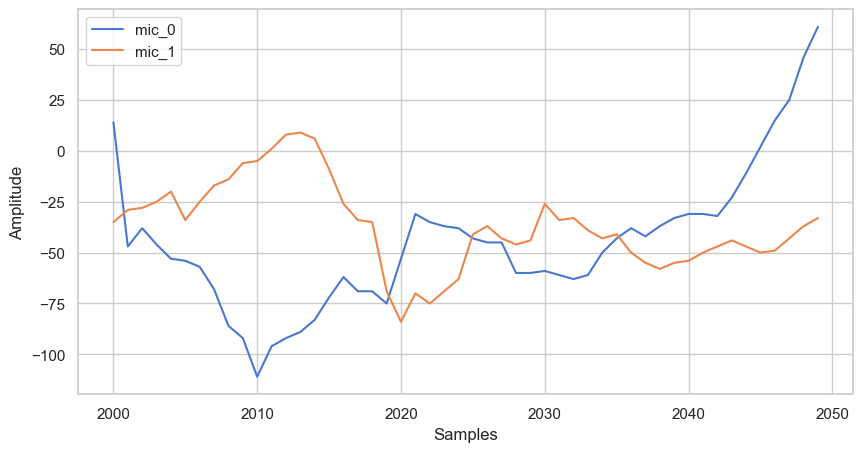

In [14]:
sns.set(style='whitegrid', palette='muted', font_scale=1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Amplitude')
ax.set_xlabel('Samples')
df.iloc[2000:2050].plot(ax=ax)
plt.show()

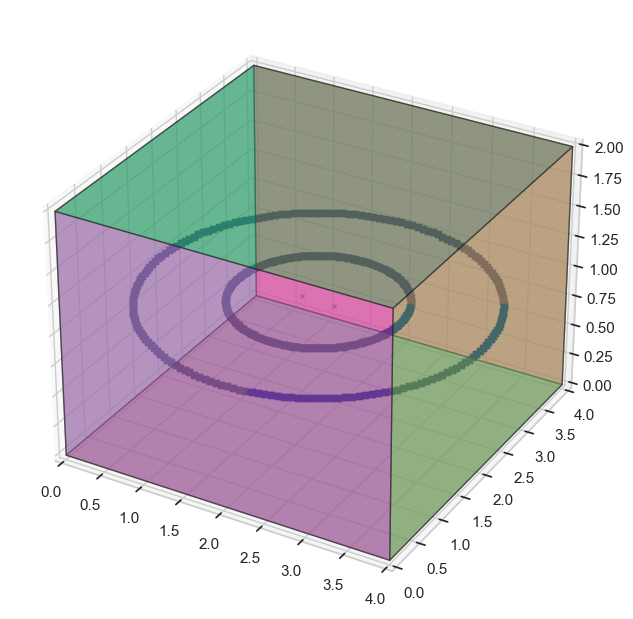

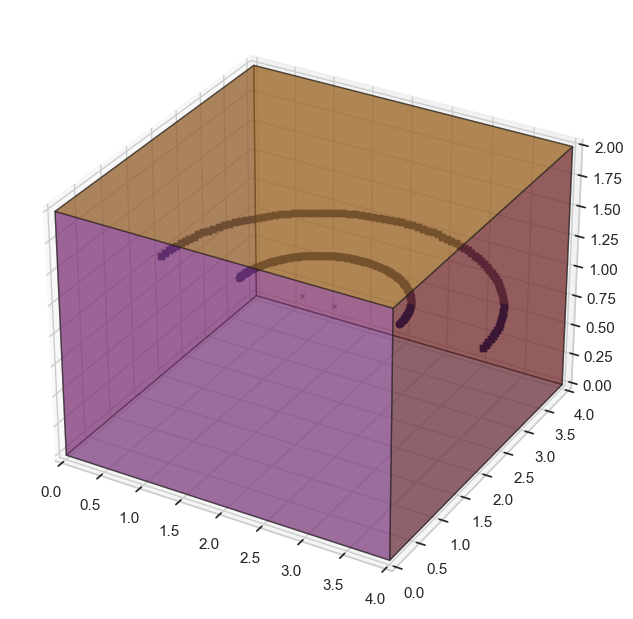

In [31]:
room_dim = ROOMS['small']

for path in AUDIO_PATH:
    room = create_simulation_room(room_dim, mic_pos=room_dim / 2)
    sources = create_sound_sources(path.max_angle, room_dim)

    def plot_room(room, sources, signal):
        # Add every single source to the room
        for angle, sources in sources.items():
            for _, _, source in sources:
                room.add_source(source, signal=signal, delay=0.5)

        # Plot the room
        fig, ax = room.plot()
        fig.set_size_inches(6, 6)
        ax.set_xlim([0, room_dim[0]])
        ax.set_ylim([0, room_dim[1]])
        ax.set_zlim([0, room_dim[2]])
        
    plot_room(room, sources, sound_files)